In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('../data/pirus_clean.csv')

# Check the first rows
data.head()


,subject_id,loc_plot_state1,loc_plot_city1,loc_plot_state2,loc_plot_city2,year_exposure,plot_target1,plot_target2,plot_target3,attack_preparation,...,trauma,other_ideologies,angry_us,group_grievance,component_id,component_density,lone_offender,degree_centrality,betweenness_centrality,closeness_centrality
0,1000,District of Columbia,Washington,Florida,-99,2002,14,NaN,NaN,1,...,0,0,0,0.0,13,0.185185,0,8,0.241538,0.472727
1,1001,California,San Francisco,NaN,NaN,2001,-88,NaN,NaN,-88,...,-99,0,1,-99.0,566,-88.000000,1,0,0.000000,0.000000
2,1002,California,Santa Ana,NaN,NaN,1997,-99,NaN,NaN,-99,...,-99,0,1,1.0,346,-88.000000,0,1,0.000000,1.000000
3,1005,New York,New York,NaN,NaN,1993,1,NaN,NaN,2,...,0,0,1,2.0,20,0.760234,0,15,0.073529,0.857143
4,1006,New York,New York,NaN,NaN,1993,1,NaN,NaN,2,...,-99,0,1,-99.0,20,0.760234,0,15,0.073529,0.857143


In [5]:

# Load cleaned data
data = pd.read_csv('../data/pirus_clean.csv')

# Define features and target
target = 'internet_radicalization'
base_features = ['social_media', 'social_media_frequency', 'media_radicalization']

# Combine platform columns
platform_cols = [
    'social_media_platform1', 'social_media_platform2', 
    'social_media_platform3', 'social_media_platform4', 'social_media_platform5'
]

# Combine activity columns
activity_cols = [
    'social_media_activities1', 'social_media_activities2', 'social_media_activities3',
    'social_media_activities4', 'social_media_activities5', 'social_media_activities6',
    'social_media_activities7'
]

# Optionally: convert platform/activity codes into categorical labels if a codebook is available

# Create dummy variables for platforms
platform_dummies = pd.get_dummies(data[platform_cols].fillna(0).astype(int).stack(), prefix='platform').groupby(level=0).sum()

# Create dummy variables for activities
activity_dummies = pd.get_dummies(data[activity_cols].fillna(0).astype(int).stack(), prefix='activity').groupby(level=0).sum()

# Combine all features
X = pd.concat([data[base_features], platform_dummies, activity_dummies], axis=1)

# Drop rows with NaN
df = pd.concat([X, data[[target]]], axis=1).dropna()

# Now split for modeling
from sklearn.model_selection import train_test_split
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data ready for training:", X_train.shape, y_train.shape)


Data ready for training: (304, 43) (304,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [8]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
    print(classification_report(y_test, y_pred))

print("Logistic Regression Performance:")
evaluate_model(lr_model, X_test, y_test)

print("Decision Tree Performance:")
evaluate_model(dt_model, X_test, y_test)


Logistic Regression Performance:
Accuracy: 0.727
              precision    recall  f1-score   support

         1.0       0.76      0.93      0.83        57
         2.0       0.43      0.15      0.22        20

    accuracy                           0.73        77
   macro avg       0.59      0.54      0.53        77
weighted avg       0.67      0.73      0.68        77

Decision Tree Performance:
Accuracy: 0.688
              precision    recall  f1-score   support

         1.0       0.78      0.81      0.79        57
         2.0       0.39      0.35      0.37        20

    accuracy                           0.69        77
   macro avg       0.58      0.58      0.58        77
weighted avg       0.68      0.69      0.68        77



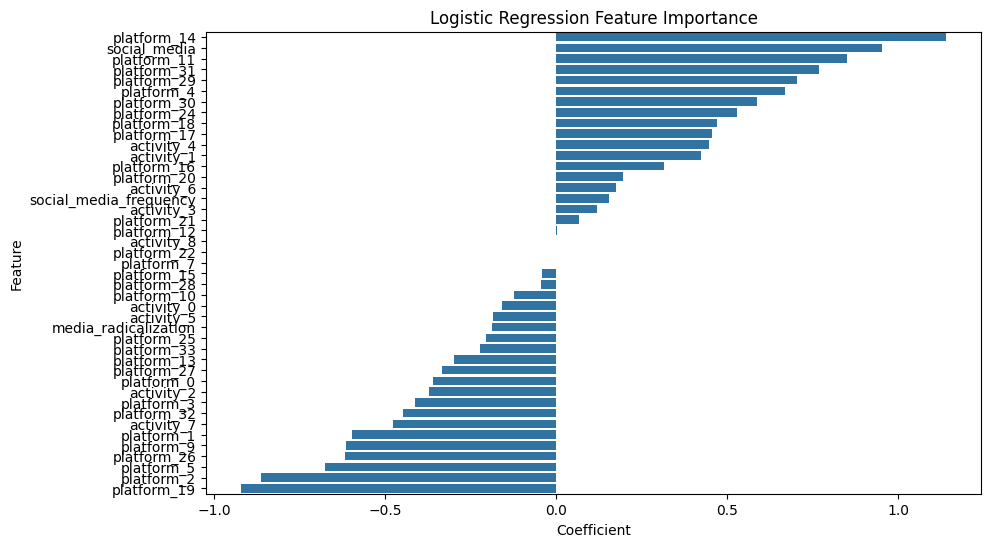

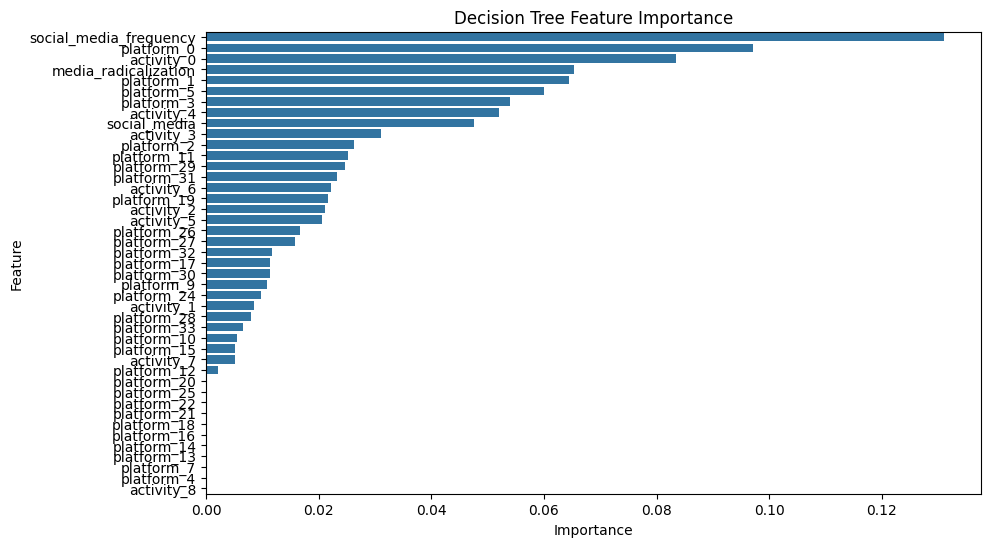

In [9]:
# Logistic Regression coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature')
plt.title('Logistic Regression Feature Importance')
plt.show()

# Decision Tree feature importance
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Decision Tree Feature Importance')
plt.show()


In [11]:
def predict_radicalization(input_dict, model=lr_model):
    """
    Predicts radicalization risk based on user input.

    Parameters:
    - input_dict: dictionary with keys matching training features
    - model: trained logistic regression or decision tree model

    Example input_dict:
    {
        'social_media': 1,
        'social_media_frequency': 3,
        'media_radicalization': 1,
        'platform_1': 1,
        'platform_2': 0,
        'activity_1': 1,
        'activity_4': 0,
        ...
    }
    """
    import pandas as pd

    # Convert input_dict to a single-row DataFrame
    input_df = pd.DataFrame([input_dict])

    # Add any missing columns (not supplied in input_dict but expected by the model)
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0

    # Ensure correct column order
    input_df = input_df[X.columns]

    # Make prediction
    prediction = model.predict(input_df)

    return prediction[0]
